In [1]:
# prompt: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset download this dataset and store as data folder

!pip install kaggle

# Assuming you have your kaggle.json in your Google Drive
# Replace with your actual path
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset -p /content/data

# Unzip the dataset
!unzip /content/data/breast-ultrasound-images-dataset.zip -d /content/data

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
 99% 193M/195M [00:10<00:00, 19.0MB/s]
100% 195M/195M [00:11<00:00, 18.4MB/s]
Archive:  /content/data/breast-ultrasound-images-dataset.zip
  inflating: /content/data/Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: /content/data/Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: /content/data/Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: /content/data/Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: /content/data/Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: /content/data/Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: /content/data/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: /content/data/Dataset_BUSI_with_GT/benign/benign 

In [2]:
# Step 1: Import Necessary Libraries
!pip install adamp
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from sklearn.metrics import precision_score, recall_score, f1_score

# Step 2: Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 3: Define Custom Dataset
class BreastDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Prepare data paths and labels
data_dir = './data/Dataset_BUSI_with_GT'
classes = ['benign', 'malignant', 'normal']
file_paths = []
labels = []

for idx, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for file in os.listdir(class_dir):
        if 'mask' not in file.lower() and file.endswith(('png', 'jpg', 'jpeg')):
            file_paths.append(os.path.join(class_dir, file))
            labels.append(idx)

# Split dataset into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42
)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),

    transforms.ToTensor(),
])

# Create DataLoader
train_dataset = BreastDataset(train_paths, train_labels, transform)
val_dataset = BreastDataset(val_paths, val_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Step 4: Define EfficientNet Model
model = models.densenet161(pretrained=True)  # Use densenet161 as a proxy for DarkNet-53
# Get the number of input features to the classifier
num_ftrs = model.classifier.in_features

# Define the new custom classifier
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(num_ftrs, len(classes)),
    nn.BatchNorm1d(len(classes))
)
model = model.to(device)
from adamp import AdamP
# Step 5: Define Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  # Apply class weights
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)
# Step 6: Train Model
def train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, epochs, patience=5
):
    best_val_acc = 0.0
    best_model_wts = None
    no_improve_epochs = 0

    # Lists to store metrics for plotting
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_f1_scores, val_f1_scores = [], []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss, train_correct = 0.0, 0
        all_train_targets, all_train_preds = [], []

        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == targets.data)

            all_train_targets.extend(targets.cpu().numpy())
            all_train_preds.extend(preds.cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct.double() / len(train_loader.dataset)
        train_precision = precision_score(all_train_targets, all_train_preds, average="weighted")
        train_recall = recall_score(all_train_targets, all_train_preds, average="weighted")
        train_f1 = f1_score(all_train_targets, all_train_preds, average="weighted")

        # Append training metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc.item())
        train_f1_scores.append(train_f1)

        # Validation Phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_val_targets, all_val_preds = [], []

        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == targets.data)

                all_val_targets.extend(targets.cpu().numpy())
                all_val_preds.extend(preds.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct.double() / len(val_loader.dataset)
        val_precision = precision_score(all_val_targets, all_val_preds, average="weighted")
        val_recall = recall_score(all_val_targets, all_val_preds, average="weighted")
        val_f1 = f1_score(all_val_targets, all_val_preds, average="weighted")

        # Append validation metrics
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())
        val_f1_scores.append(val_f1)

        # Scheduler step
        scheduler.step(val_loss)

        # Print metrics
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

        # Early Stopping Logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)
        print(f"Loaded best model weights with Val Acc: {best_val_acc:.4f}")
    else:
        print("No improvement during training.")

    return train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores

# Start Training and Retrieve Metrics
train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=20
)

  Preparing metadata (setup.py) ... done
  Created wheel for adamp: filename=adamp-0.3.0-py3-none-any.whl size=5984 sha256=10da06fe33325f8fb6c74811df491444136a802d2891ce6d4a42c77ef64afdb4
  Stored in directory: /root/.cache/pip/wheels/c7/ad/0f/b41b1c45b18c66e5eef5d2254415af8055c7e2b0934145157d
Successfully built adamp


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 192MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warn

Epoch 1/20
Train Loss: 0.8790, Train Acc: 0.5513, Precision: 0.6723, Recall: 0.5513, F1: 0.5667
Val Loss: 1.1402, Val Acc: 0.6090, Precision: 0.5898, Recall: 0.6090, F1: 0.5738


Epoch 2/20 - Validation: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 2/20
Train Loss: 0.6984, Train Acc: 0.6538, Precision: 0.7449, Recall: 0.6538, F1: 0.6647
Val Loss: 0.7373, Val Acc: 0.6410, Precision: 0.7321, Recall: 0.6410, F1: 0.6481


Epoch 3/20 - Validation: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 3/20
Train Loss: 0.6250, Train Acc: 0.7308, Precision: 0.7808, Recall: 0.7308, F1: 0.7366
Val Loss: 0.7726, Val Acc: 0.6474, Precision: 0.7835, Recall: 0.6474, F1: 0.6544


Epoch 4/20 - Validation: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 4/20
Train Loss: 0.5580, Train Acc: 0.7308, Precision: 0.7939, Recall: 0.7308, F1: 0.7342
Val Loss: 0.6170, Val Acc: 0.7244, Precision: 0.7816, Recall: 0.7244, F1: 0.7293


Epoch 5/20 - Validation: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 5/20
Train Loss: 0.5749, Train Acc: 0.7484, Precision: 0.7954, Recall: 0.7484, F1: 0.7531
Val Loss: 0.6116, Val Acc: 0.7051, Precision: 0.7969, Recall: 0.7051, F1: 0.7007


Epoch 6/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 6/20
Train Loss: 0.5542, Train Acc: 0.7596, Precision: 0.8059, Recall: 0.7596, F1: 0.7670
Val Loss: 0.5852, Val Acc: 0.8077, Precision: 0.8122, Recall: 0.8077, F1: 0.8073


Epoch 7/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 7/20
Train Loss: 0.5260, Train Acc: 0.7564, Precision: 0.7944, Recall: 0.7564, F1: 0.7600
Val Loss: 0.6719, Val Acc: 0.7372, Precision: 0.7662, Recall: 0.7372, F1: 0.7435


Epoch 8/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 8/20
Train Loss: 0.4825, Train Acc: 0.7837, Precision: 0.8119, Recall: 0.7837, F1: 0.7866
Val Loss: 0.5991, Val Acc: 0.7436, Precision: 0.7904, Recall: 0.7436, F1: 0.7514


Epoch 9/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 9/20
Train Loss: 0.4574, Train Acc: 0.8173, Precision: 0.8501, Recall: 0.8173, F1: 0.8201
Val Loss: 0.5005, Val Acc: 0.7821, Precision: 0.8082, Recall: 0.7821, F1: 0.7831


Epoch 10/20 - Validation: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 10/20
Train Loss: 0.4205, Train Acc: 0.8317, Precision: 0.8543, Recall: 0.8317, F1: 0.8333
Val Loss: 0.4610, Val Acc: 0.8205, Precision: 0.8452, Recall: 0.8205, F1: 0.8239


Epoch 11/20 - Validation: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 11/20
Train Loss: 0.3788, Train Acc: 0.8638, Precision: 0.8836, Recall: 0.8638, F1: 0.8650
Val Loss: 0.4428, Val Acc: 0.8333, Precision: 0.8477, Recall: 0.8333, F1: 0.8346


Epoch 12/20 - Validation: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 12/20
Train Loss: 0.4064, Train Acc: 0.8462, Precision: 0.8656, Recall: 0.8462, F1: 0.8484
Val Loss: 0.4141, Val Acc: 0.8141, Precision: 0.8357, Recall: 0.8141, F1: 0.8146


Epoch 13/20 - Validation: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 13/20
Train Loss: 0.3548, Train Acc: 0.8910, Precision: 0.9074, Recall: 0.8910, F1: 0.8924
Val Loss: 0.4061, Val Acc: 0.8205, Precision: 0.8340, Recall: 0.8205, F1: 0.8211


Epoch 14/20 - Validation: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 14/20
Train Loss: 0.3278, Train Acc: 0.8958, Precision: 0.9034, Recall: 0.8958, F1: 0.8966
Val Loss: 0.4656, Val Acc: 0.8205, Precision: 0.8291, Recall: 0.8205, F1: 0.8214


Epoch 15/20 - Validation: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 15/20
Train Loss: 0.3437, Train Acc: 0.9022, Precision: 0.9099, Recall: 0.9022, F1: 0.9030
Val Loss: 0.4325, Val Acc: 0.8590, Precision: 0.8742, Recall: 0.8590, F1: 0.8609


Epoch 16/20 - Validation: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 16/20
Train Loss: 0.3100, Train Acc: 0.9022, Precision: 0.9151, Recall: 0.9022, F1: 0.9035
Val Loss: 0.4000, Val Acc: 0.8462, Precision: 0.8539, Recall: 0.8462, F1: 0.8459


Epoch 17/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 17/20
Train Loss: 0.3058, Train Acc: 0.9135, Precision: 0.9257, Recall: 0.9135, F1: 0.9145
Val Loss: 0.4069, Val Acc: 0.8654, Precision: 0.8726, Recall: 0.8654, F1: 0.8659


Epoch 18/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 18/20
Train Loss: 0.3064, Train Acc: 0.9183, Precision: 0.9263, Recall: 0.9183, F1: 0.9194
Val Loss: 0.3826, Val Acc: 0.8654, Precision: 0.8731, Recall: 0.8654, F1: 0.8656


Epoch 19/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 19/20
Train Loss: 0.3303, Train Acc: 0.9006, Precision: 0.9128, Recall: 0.9006, F1: 0.9018
Val Loss: 0.3825, Val Acc: 0.8974, Precision: 0.8996, Recall: 0.8974, F1: 0.8971


Epoch 20/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

Epoch 20/20
Train Loss: 0.3111, Train Acc: 0.9135, Precision: 0.9231, Recall: 0.9135, F1: 0.9142
Val Loss: 0.3832, Val Acc: 0.9038, Precision: 0.9068, Recall: 0.9038, F1: 0.9039
Loaded best model weights with Val Acc: 0.9038


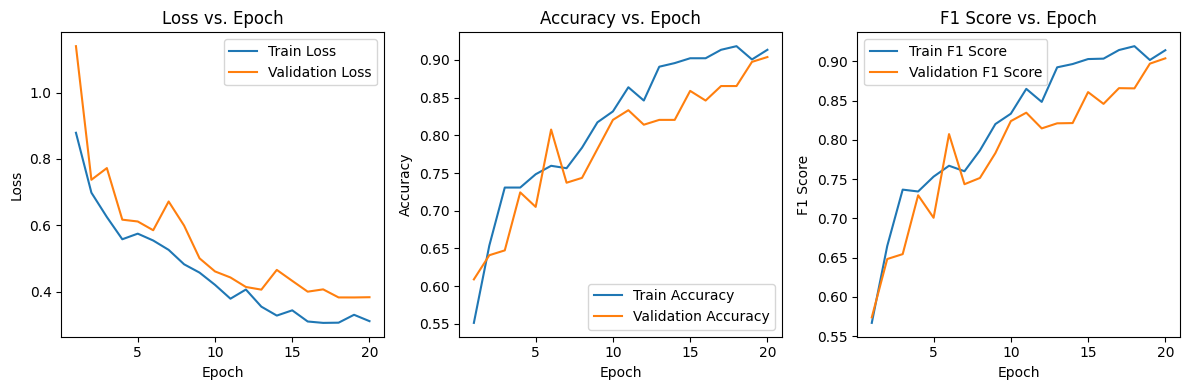

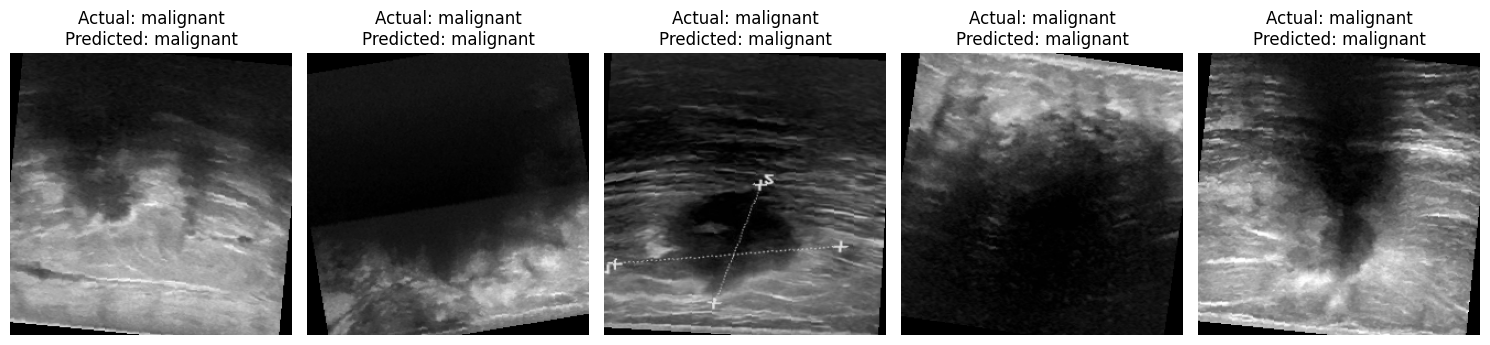

In [4]:

import matplotlib.pyplot as plt

# Plot Loss vs. Epoch
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()

# Plot Accuracy vs. Epoch
plt.subplot(1, 3, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()

# Plot F1 Score vs. Epoch
plt.subplot(1, 3, 3)
plt.plot(range(1, len(train_f1_scores) + 1), train_f1_scores, label="Train F1 Score")
plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label="Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Epoch")
plt.legend()

plt.tight_layout()
plt.show()




In [5]:
# prompt: save and download the model

# Save the model's state dictionary
torch.save(model.state_dict(), 'breast_cancer_model.pth')

# Download the saved model file
from google.colab import files
files.download('breast_cancer_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

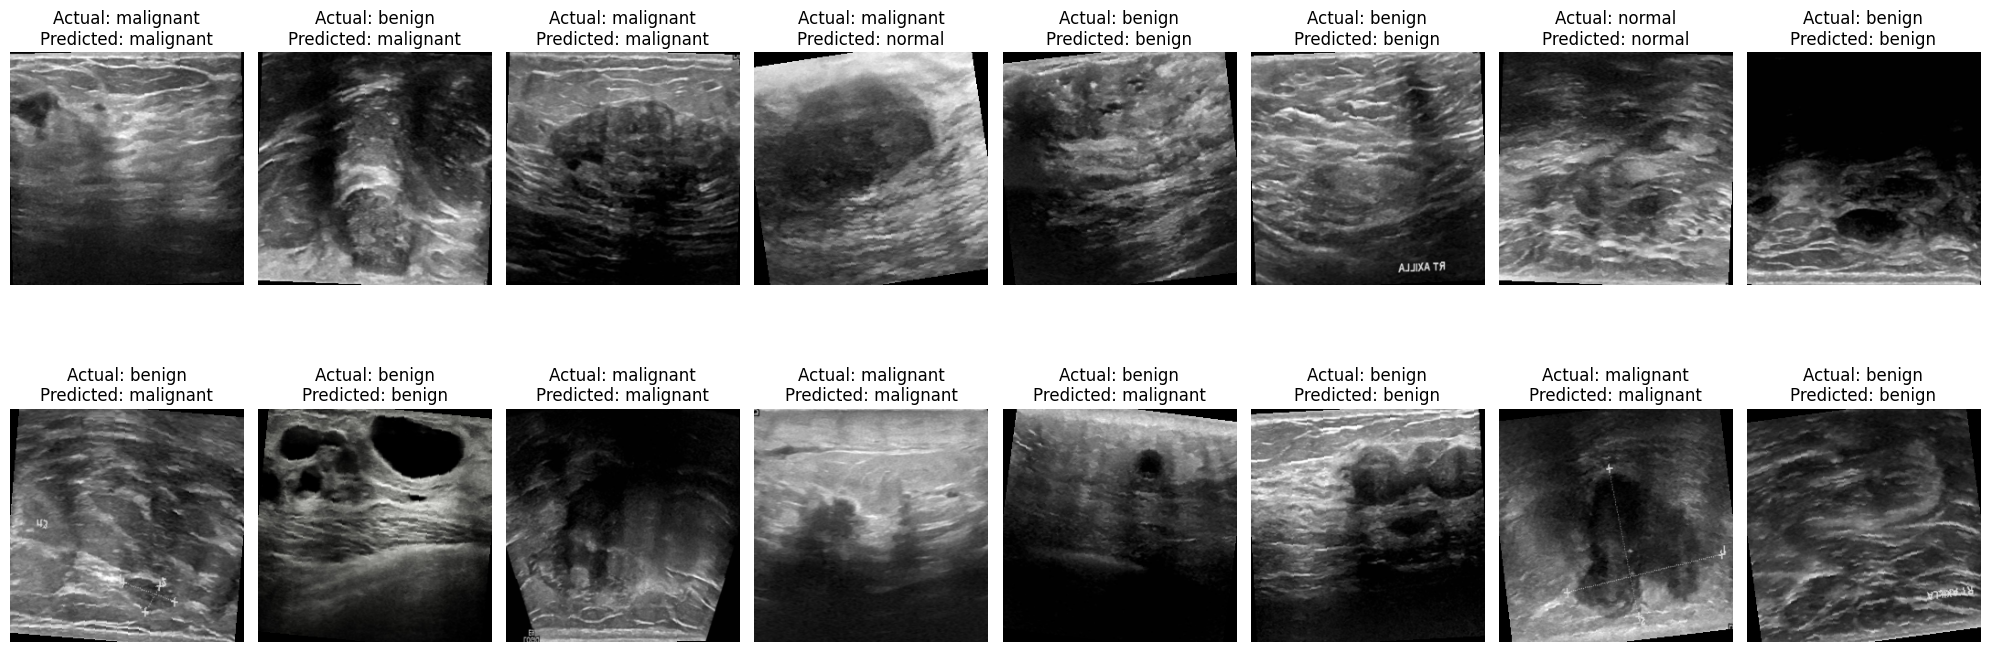

In [13]:
def visualize_predictions(model, data_loader, class_names, num_samples=16):
    model.eval()
    fig, axes = plt.subplots(2, 8, figsize=(20, 8))
    axes = axes.flatten()

    indices = list(range(len(data_loader.dataset)))
    random_indices = random.sample(indices, num_samples)

    with torch.no_grad():
        for i, index in enumerate(random_indices):
            inputs, targets = data_loader.dataset[index]
            inputs = inputs.unsqueeze(0).to(device)  # Add batch dimension
            targets = torch.tensor([targets]).to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            ax = axes[i]
            img = inputs[0].cpu().numpy().transpose((1, 2, 0))
            ax.imshow(img)
            ax.set_title(f"Actual: {class_names[targets[0]]}\nPredicted: {class_names[preds[0]]}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Call visualization
class_names = ["benign", "malignant", "normal"]
visualize_predictions(model, val_loader, class_names)